In [1]:
from scipy.special import logit
from shap.maskers import Independent
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from plots import plot_shap_value_distribution, plot_shap_partial_dependence, plot_shap_values_stacked, \
    plot_shap_values_hierarchically_clustered, plot_decision_boundary
import shap
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
shap.initjs()
np.seterr(all='ignore');

# Decision Tree vs. KNN
Based on ["Classifier comparison"](https://scikit-learn.org/0.24/auto_examples/classification/plot_classifier_comparison.html) example of scikit-learn docs.

## Create Models

In [2]:
feature_names = ['x1', 'x2']
X, y = make_circles(n_samples=500, noise=0.2, factor=0.5, random_state=1)
X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=.8, random_state=42)

In [3]:
m1 = DecisionTreeClassifier(max_depth=5)
m1.fit(X_train, y_train)
logit_from_log_proba = lambda Y: Y[:,1] - Y[:,0]
f1 = lambda X: logit_from_log_proba(m1.predict_log_proba(X))
c1 = lambda X: m1.predict_proba(X)[:,1]

In [4]:
m2 = KNeighborsClassifier(3)
m2.fit(X_train, y_train)
f2 = lambda X: logit(m2.predict_proba(X)[:,1])
c2 = lambda X: m2.predict_proba(X)[:,1]

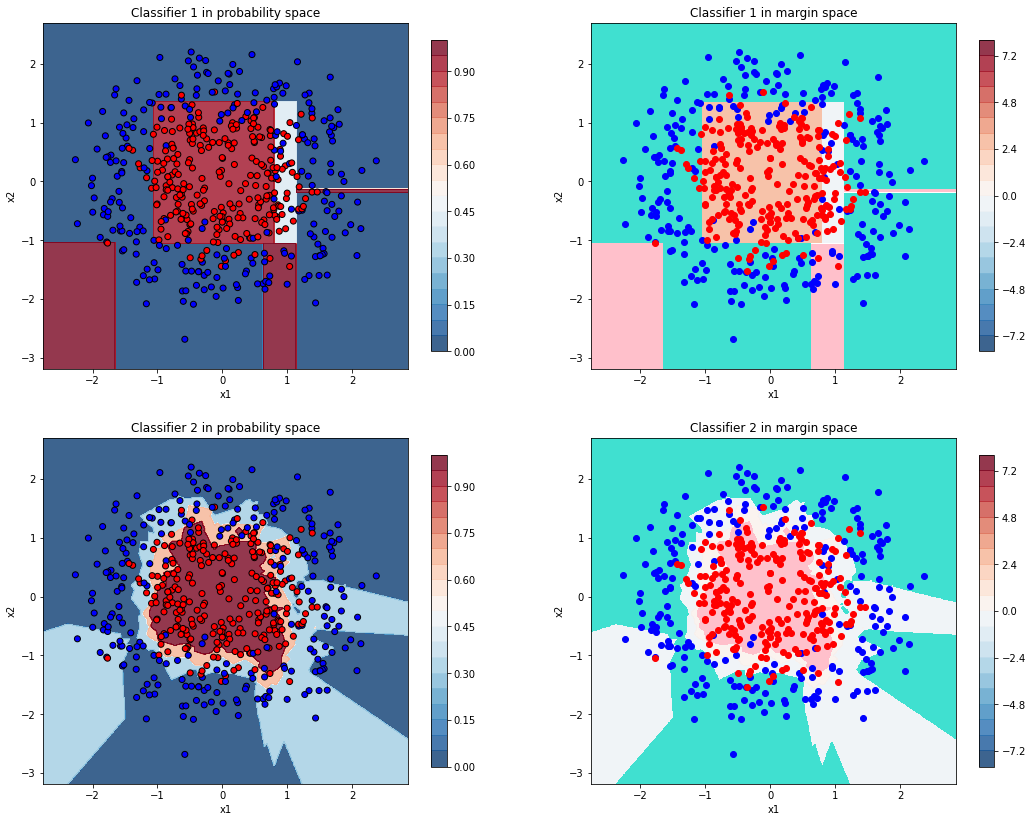

In [5]:
fig, axs = plt.subplots(2, 2, figsize=(18, 14))
plot_decision_boundary(c1, X, 'Classifier 1 in probability space', feature_names, (0, 1), fig, axs[0,0], y)
plot_decision_boundary(c2, X, 'Classifier 2 in probability space', feature_names, (0, 1), fig, axs[1,0], y)
plot_decision_boundary(f1, X, 'Classifier 1 in margin space', feature_names, (-8, 8), fig, axs[0,1], logit(y))
plot_decision_boundary(f2, X, 'Classifier 2 in margin space', feature_names, (-8, 8), fig, axs[1,1], logit(y))
plt.show()

In [6]:
complement = lambda p: 1 - p
c1_positive_and_c2_negative = lambda p1, p2: p1 * complement(p2)
c1_negative_and_c2_positive = lambda p1, p2: complement(p1) * p2
c1_and_c2_different = lambda p1, p2: c1_positive_and_c2_negative(p1, p2) + c1_negative_and_c2_positive(p1, p2)

c_c1_positive_and_c2_negative = lambda X: c1_positive_and_c2_negative(c1(X), c2(X))
c_c1_negative_and_c2_positive = lambda X: c1_negative_and_c2_positive(c1(X), c2(X))
c_c1_and_c2_different = lambda X: c1_and_c2_different(c1(X), c2(X))

In [7]:
odds = lambda p: p / complement(p)
log_odds_ratio_from_proba = lambda p1, p2: np.log(odds(p1) / odds(p2))
log_odds_ratio = lambda y1, y2: y1 - y2

f_c1_positive_and_c2_negative = lambda X: logit(c_c1_positive_and_c2_negative(X))
f_c1_negative_and_c2_positive = lambda X: logit(c_c1_negative_and_c2_positive(X))
f_c1_and_c2_different = lambda X: logit(c_c1_and_c2_different(X))
f_log_odds_ratio = lambda X: log_odds_ratio(f1(X), f2(X))

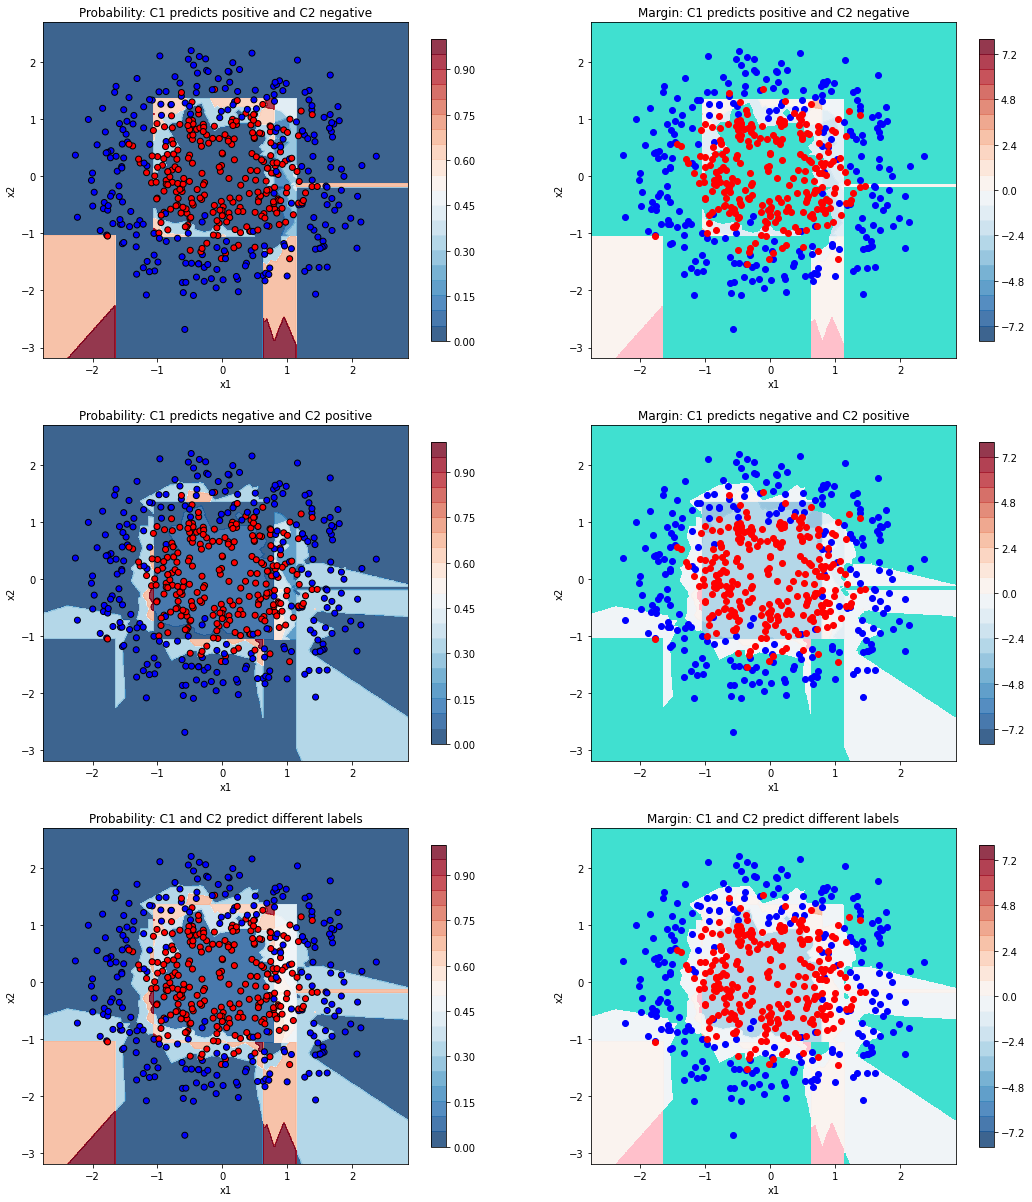

In [8]:
fig, axs = plt.subplots(3, 2, figsize=(18, 21))
plot_decision_boundary(c_c1_positive_and_c2_negative, X, 'Probability: C1 predicts positive and C2 negative', feature_names, (0, 1), fig, axs[0,0], y)
plot_decision_boundary(c_c1_negative_and_c2_positive, X, 'Probability: C1 predicts negative and C2 positive', feature_names, (0, 1), fig, axs[1,0], y)
plot_decision_boundary(c_c1_and_c2_different, X, 'Probability: C1 and C2 predict different labels', feature_names, (0, 1), fig, axs[2,0], y)
plot_decision_boundary(f_c1_positive_and_c2_negative, X, 'Margin: C1 predicts positive and C2 negative', feature_names, (-8, 8), fig, axs[0,1], logit(y))
plot_decision_boundary(f_c1_negative_and_c2_positive, X, 'Margin: C1 predicts negative and C2 positive', feature_names, (-8, 8), fig, axs[1,1], logit(y))
plot_decision_boundary(f_c1_and_c2_different, X, 'Margin: C1 and C2 predict different labels', feature_names, (-8, 8), fig, axs[2,1], logit(y))
plt.show()

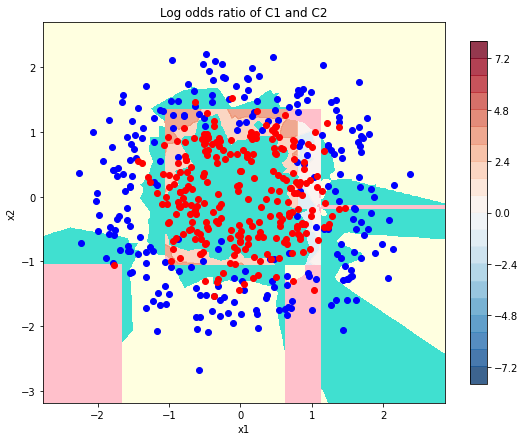

In [9]:
plot_decision_boundary(f_log_odds_ratio, X, 'Log odds ratio of C1 and C2', feature_names, (-8, 8), z=logit(y))

## Generate Explanations

In [10]:
def make_shap_values(model, background_data, feature_names):
    masker = Independent(background_data)
    explainer = shap.Explainer(model, masker, feature_names=feature_names)
    shap_values = explainer(X)
    return shap_values

shap_values_c1 = make_shap_values(c1, X, feature_names)
shap_values_c2 = make_shap_values(c2, X, feature_names)
shap_values_f1 = make_shap_values(f1, X, feature_names)
shap_values_f2 = make_shap_values(f2, X, feature_names)

In [11]:
shap_values_c_c1_positive_and_c2_negative = make_shap_values(c_c1_positive_and_c2_negative, X, feature_names)
shap_values_c_c1_negative_and_c2_positive = make_shap_values(c_c1_negative_and_c2_positive, X, feature_names)
shap_values_c_c1_and_c2_different = make_shap_values(c_c1_and_c2_different, X, feature_names)
shap_values_f_c1_positive_and_c2_negative = make_shap_values(f_c1_positive_and_c2_negative, X, feature_names)
shap_values_f_c1_negative_and_c2_positive = make_shap_values(f_c1_negative_and_c2_positive, X, feature_names)
shap_values_f_c1_and_c2_different = make_shap_values(f_c1_and_c2_different, X, feature_names)
shap_values_f_log_odds_ratio = make_shap_values(f_log_odds_ratio, X, feature_names)

## Analyze

### SHAP Value Distribution

#### Probability Space

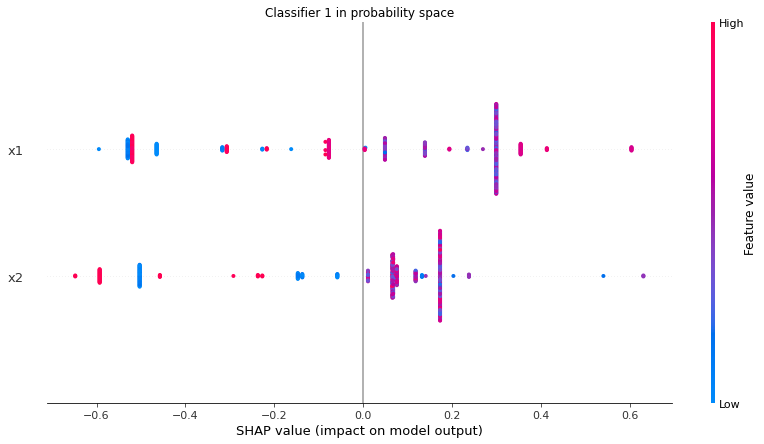

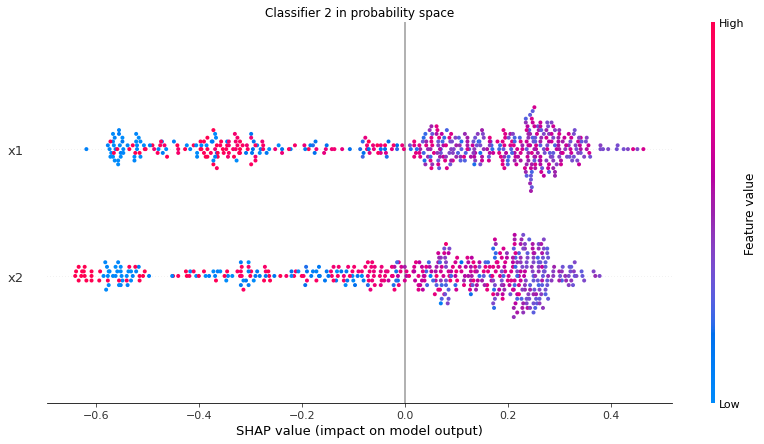

In [12]:
plot_shap_value_distribution(shap_values_c1, 'Classifier 1 in probability space')
plot_shap_value_distribution(shap_values_c2, 'Classifier 2 in probability space')

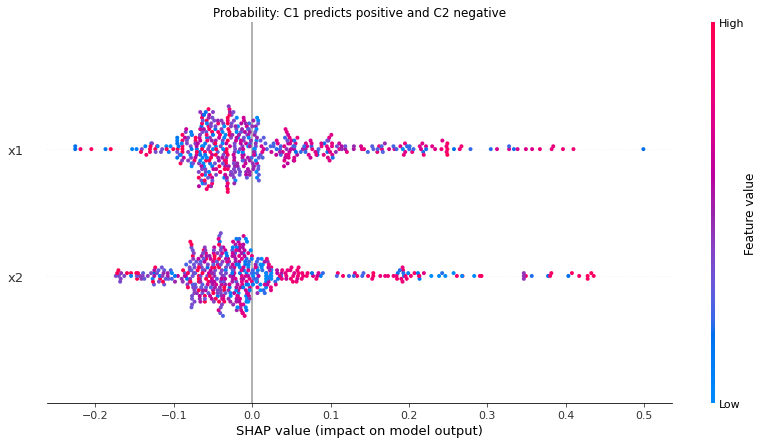

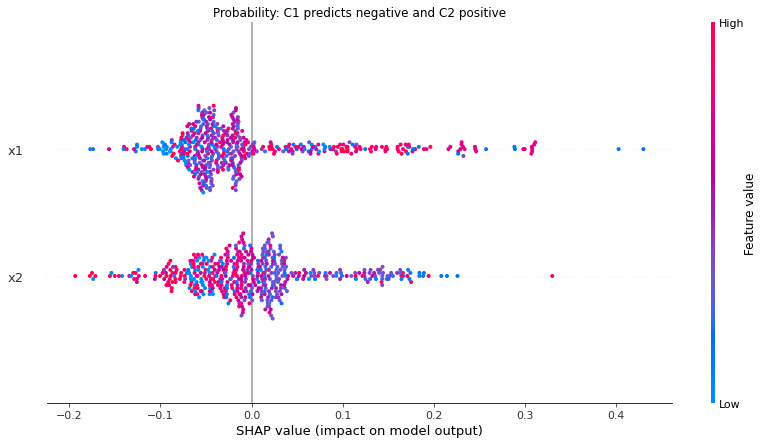

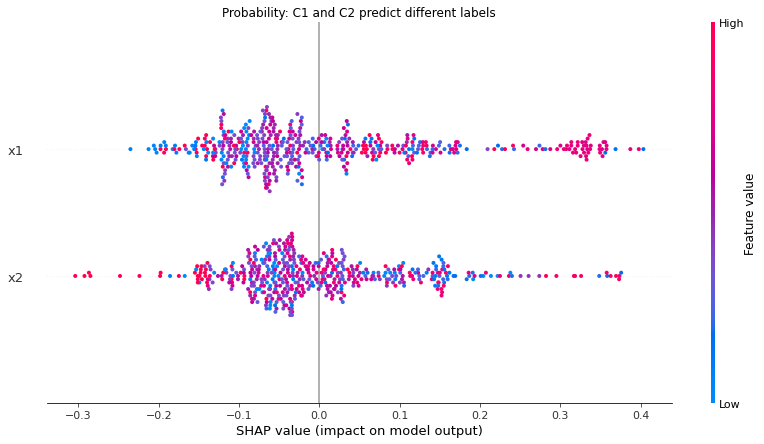

In [13]:
plot_shap_value_distribution(shap_values_c_c1_positive_and_c2_negative, 'C1 predicts positive and C2 negative')
plot_shap_value_distribution(shap_values_c_c1_negative_and_c2_positive, 'C1 predicts negative and C2 positive')
plot_shap_value_distribution(shap_values_c_c1_and_c2_different, 'C1 and C2 predict different labels')

#### Margin Space

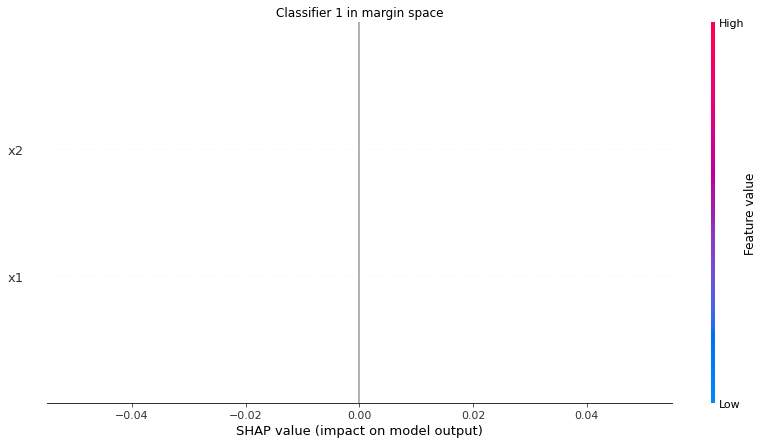

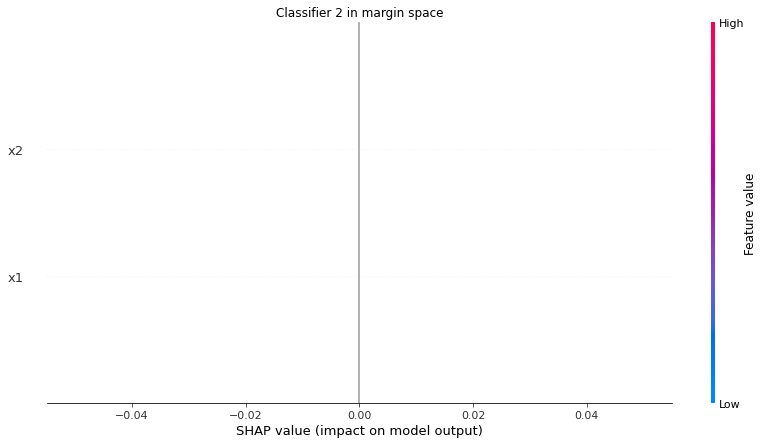

In [14]:
plot_shap_value_distribution(shap_values_f1, 'Classifier 1 in margin space')
plot_shap_value_distribution(shap_values_f2, 'Classifier 2 in margin space')

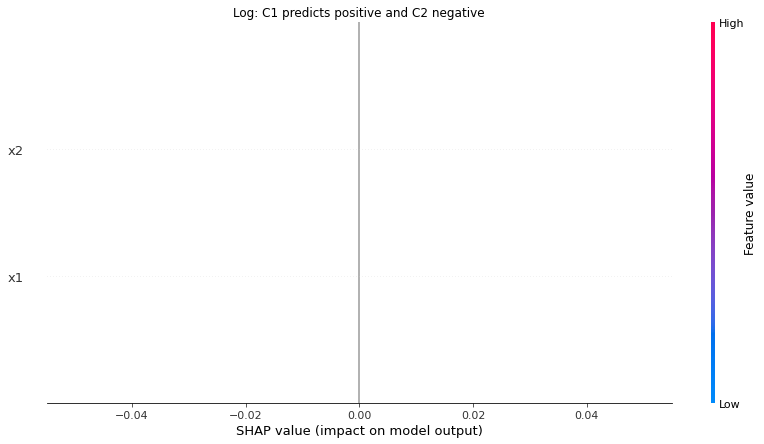

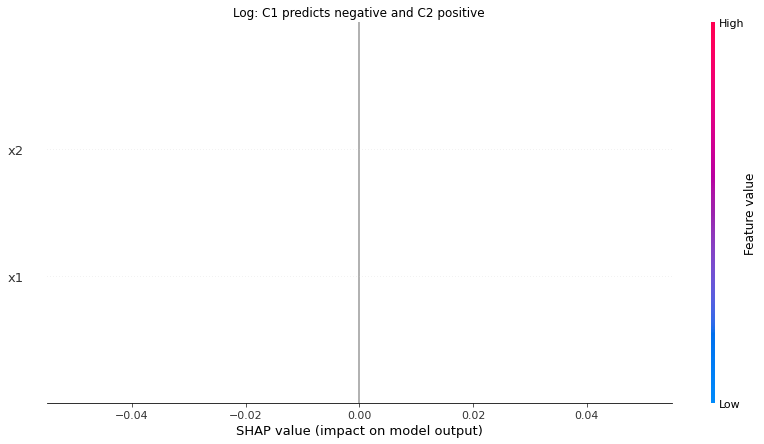

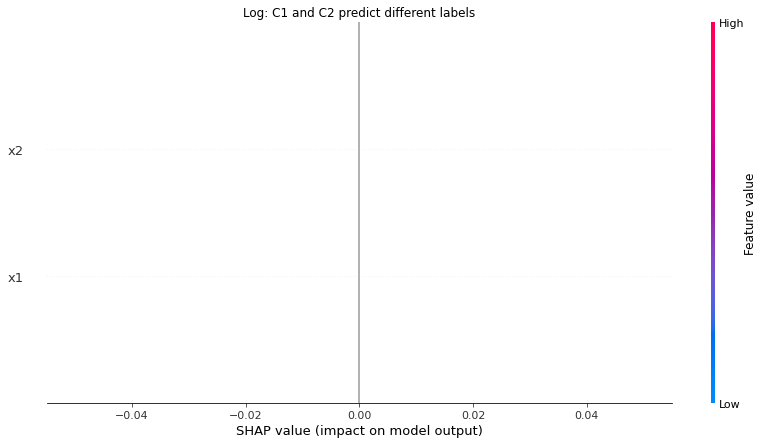

In [15]:
plot_shap_value_distribution(shap_values_f_c1_positive_and_c2_negative, 'C1 predicts positive and C2 negative')
plot_shap_value_distribution(shap_values_f_c1_negative_and_c2_positive, 'C1 predicts negative and C2 positive')
plot_shap_value_distribution(shap_values_f_c1_and_c2_different, 'C1 and C2 predict different labels')

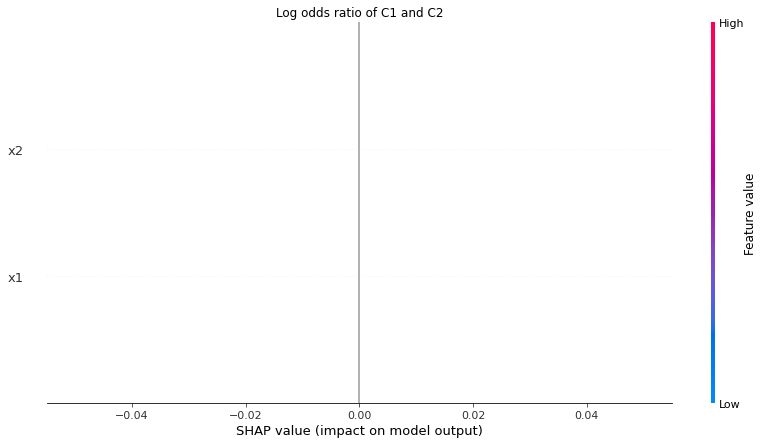

In [16]:
plot_shap_value_distribution(shap_values_f_log_odds_ratio, 'Log odds ratio of C1 and C2')

### Features' Partial Dependence Plots

#### Probability Space

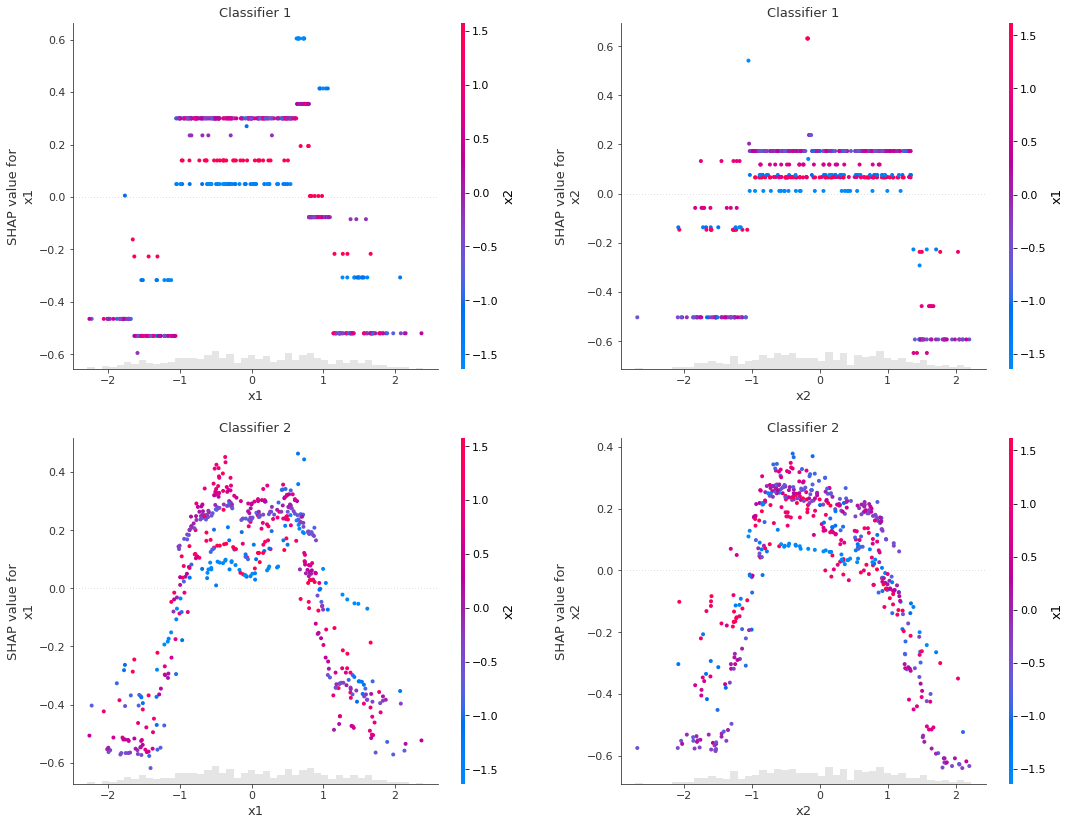

In [17]:
ylim = None
fig, axs = plt.subplots(2, 2, figsize=(18, 14))
plot_shap_partial_dependence(shap_values_c1, feature_names[0], 'Classifier 1', ylim, axs[0,0])
plot_shap_partial_dependence(shap_values_c1, feature_names[1], 'Classifier 1', ylim, axs[0,1])
plot_shap_partial_dependence(shap_values_c2, feature_names[0], 'Classifier 2', ylim, axs[1,0])
plot_shap_partial_dependence(shap_values_c2, feature_names[1], 'Classifier 2', ylim, axs[1,1])
plt.show()

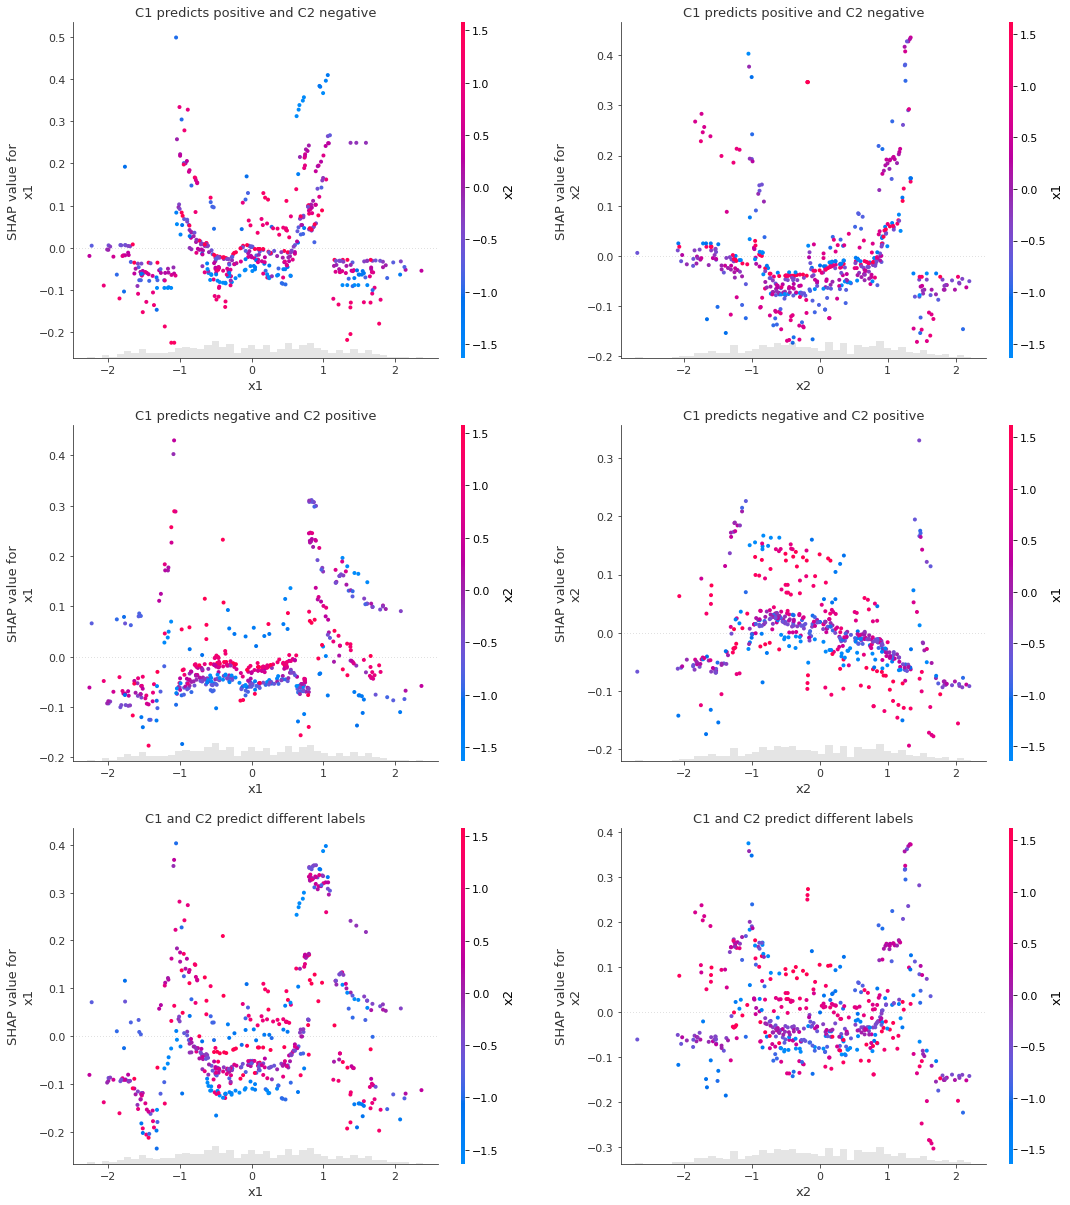

In [18]:
ylim = None
fig, axs = plt.subplots(3, 2, figsize=(18, 21))
plot_shap_partial_dependence(shap_values_c_c1_positive_and_c2_negative, feature_names[0], 'C1 predicts positive and C2 negative', ylim, axs[0,0])
plot_shap_partial_dependence(shap_values_c_c1_positive_and_c2_negative, feature_names[1], 'C1 predicts positive and C2 negative', ylim, axs[0,1])
plot_shap_partial_dependence(shap_values_c_c1_negative_and_c2_positive, feature_names[0], 'C1 predicts negative and C2 positive', ylim, axs[1,0])
plot_shap_partial_dependence(shap_values_c_c1_negative_and_c2_positive, feature_names[1], 'C1 predicts negative and C2 positive', ylim, axs[1,1])
plot_shap_partial_dependence(shap_values_c_c1_and_c2_different, feature_names[0], 'C1 and C2 predict different labels', ylim, axs[2,0])
plot_shap_partial_dependence(shap_values_c_c1_and_c2_different, feature_names[1], 'C1 and C2 predict different labels', ylim, axs[2,1])
plt.show()

#### Margin Space

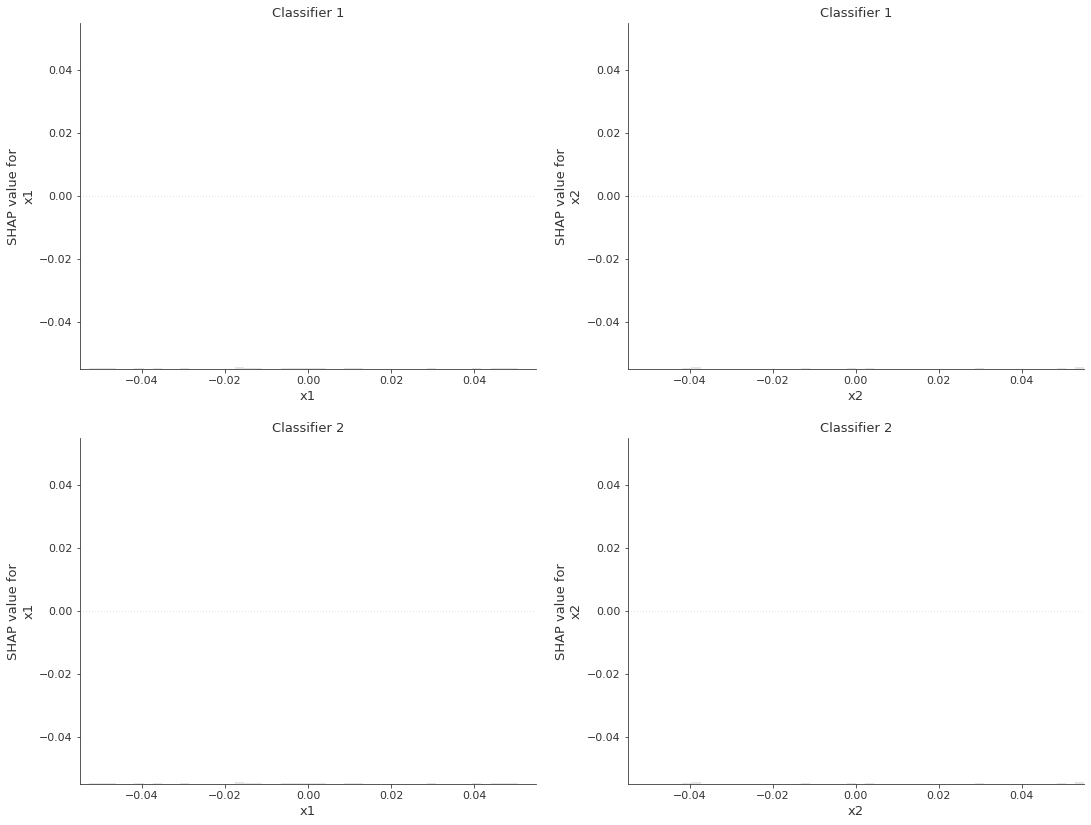

In [19]:
ylim = None
fig, axs = plt.subplots(2, 2, figsize=(18, 14))
plot_shap_partial_dependence(shap_values_f1, feature_names[0], 'Classifier 1', ylim, axs[0,0])
plot_shap_partial_dependence(shap_values_f1, feature_names[1], 'Classifier 1', ylim, axs[0,1])
plot_shap_partial_dependence(shap_values_f2, feature_names[0], 'Classifier 2', ylim, axs[1,0])
plot_shap_partial_dependence(shap_values_f2, feature_names[1], 'Classifier 2', ylim, axs[1,1])
plt.show()

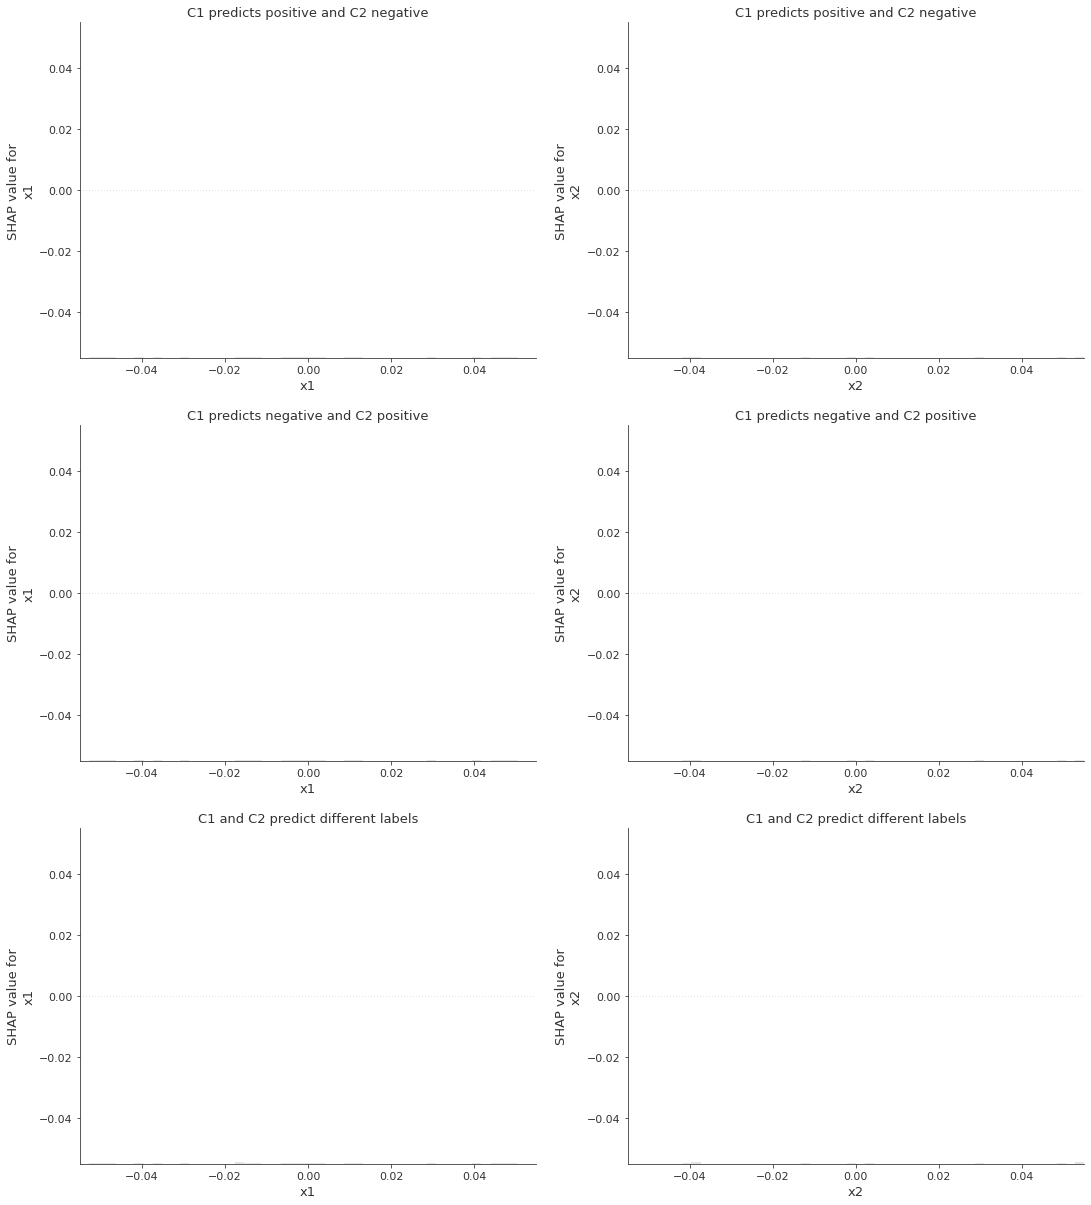

In [20]:
ylim = None
fig, axs = plt.subplots(3, 2, figsize=(18, 21))
plot_shap_partial_dependence(shap_values_f_c1_positive_and_c2_negative, feature_names[0], 'C1 predicts positive and C2 negative', ylim, axs[0,0])
plot_shap_partial_dependence(shap_values_f_c1_positive_and_c2_negative, feature_names[1], 'C1 predicts positive and C2 negative', ylim, axs[0,1])
plot_shap_partial_dependence(shap_values_f_c1_negative_and_c2_positive, feature_names[0], 'C1 predicts negative and C2 positive', ylim, axs[1,0])
plot_shap_partial_dependence(shap_values_f_c1_negative_and_c2_positive, feature_names[1], 'C1 predicts negative and C2 positive', ylim, axs[1,1])
plot_shap_partial_dependence(shap_values_f_c1_and_c2_different, feature_names[0], 'C1 and C2 predict different labels', ylim, axs[2,0])
plot_shap_partial_dependence(shap_values_f_c1_and_c2_different, feature_names[1], 'C1 and C2 predict different labels', ylim, axs[2,1])
plt.show()

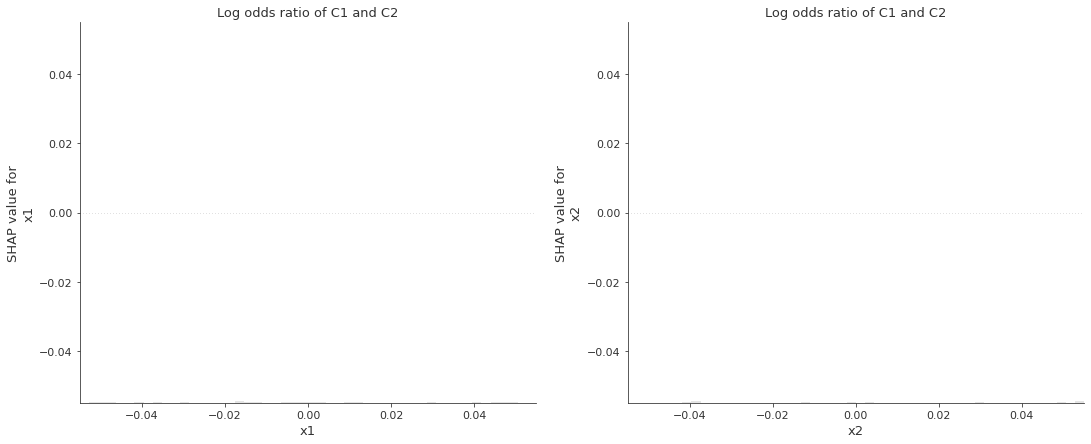

In [21]:
ylim = None
fig, axs = plt.subplots(1, 2, figsize=(18, 7))
plot_shap_partial_dependence(shap_values_f_log_odds_ratio, feature_names[0], 'Log odds ratio of C1 and C2', ylim, axs[0])
plot_shap_partial_dependence(shap_values_f_log_odds_ratio, feature_names[1], 'Log odds ratio of C1 and C2', ylim, axs[1])
plt.show()

### Stacked SHAP Explanations, Clustered by Similarity

#### Probability Space

In [22]:
ordering = plot_shap_values_stacked(shap_values_c1, 'Classifier 1')
plot_shap_values_stacked(shap_values_c2, 'Classifier 2', ordering);

In [23]:
plot_shap_values_stacked(shap_values_c_c1_positive_and_c2_negative, 'C1 predicts positive and C2 negative')
plot_shap_values_stacked(shap_values_c_c1_negative_and_c2_positive, 'C1 predicts negative and C2 positive')
plot_shap_values_stacked(shap_values_c_c1_and_c2_different, 'C1 and C2 predict different labels');

#### Margin Space

In [24]:
ordering = plot_shap_values_stacked(shap_values_f1, 'Classifier 1')
plot_shap_values_stacked(shap_values_f2, 'Classifier 2', ordering);

Omitting plot because of ValueError: The condensed distance matrix must contain only finite values.
Omitting plot because of ValueError: The condensed distance matrix must contain only finite values.


In [25]:
plot_shap_values_stacked(shap_values_f_c1_positive_and_c2_negative, 'C1 predicts positive and C2 negative')
plot_shap_values_stacked(shap_values_f_c1_negative_and_c2_positive, 'C1 predicts negative and C2 positive')
plot_shap_values_stacked(shap_values_f_c1_and_c2_different, 'C1 and C2 predict different labels');

Omitting plot because of ValueError: The condensed distance matrix must contain only finite values.
Omitting plot because of ValueError: The condensed distance matrix must contain only finite values.
Omitting plot because of ValueError: The condensed distance matrix must contain only finite values.


In [26]:
plot_shap_values_stacked(shap_values_f_log_odds_ratio, 'Log odds ratio of C1 and C2');

Omitting plot because of ValueError: The condensed distance matrix must contain only finite values.


### Hierarchically Clustered SHAP Values

#### Probability Space

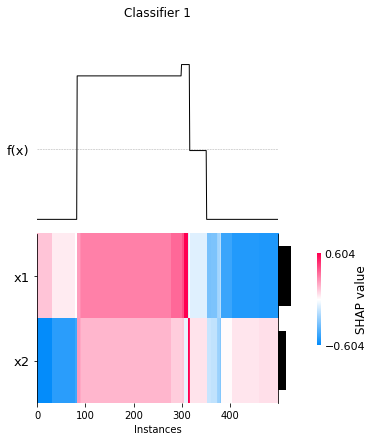

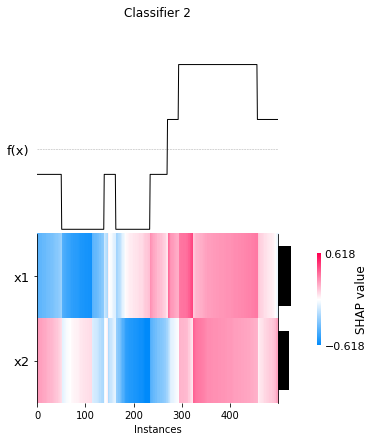

In [27]:
plot_shap_values_hierarchically_clustered(shap_values_c1, 'Classifier 1')
plot_shap_values_hierarchically_clustered(shap_values_c2, 'Classifier 2')

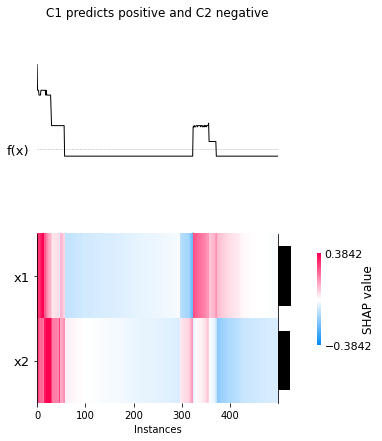

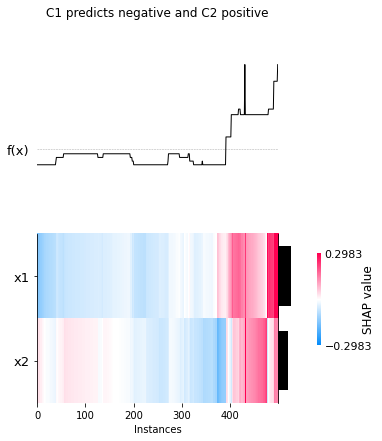

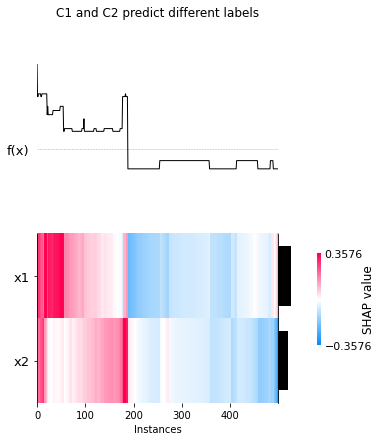

In [28]:
plot_shap_values_hierarchically_clustered(shap_values_c_c1_positive_and_c2_negative, 'C1 predicts positive and C2 negative')
plot_shap_values_hierarchically_clustered(shap_values_c_c1_negative_and_c2_positive, 'C1 predicts negative and C2 positive')
plot_shap_values_hierarchically_clustered(shap_values_c_c1_and_c2_different, 'C1 and C2 predict different labels')

#### Margin Space

In [29]:
plot_shap_values_hierarchically_clustered(shap_values_f1, 'Classifier 1')
plot_shap_values_hierarchically_clustered(shap_values_f2, 'Classifier 2')

Omitting plot because of ValueError: The condensed distance matrix must contain only finite values.
Omitting plot because of ValueError: The condensed distance matrix must contain only finite values.


In [30]:
plot_shap_values_hierarchically_clustered(shap_values_f_c1_positive_and_c2_negative, 'C1 predicts positive and C2 negative')
plot_shap_values_hierarchically_clustered(shap_values_f_c1_negative_and_c2_positive, 'C1 predicts negative and C2 positive')
plot_shap_values_hierarchically_clustered(shap_values_f_c1_and_c2_different, 'C1 and C2 predict different labels')

Omitting plot because of ValueError: The condensed distance matrix must contain only finite values.
Omitting plot because of ValueError: The condensed distance matrix must contain only finite values.
Omitting plot because of ValueError: The condensed distance matrix must contain only finite values.


In [31]:
plot_shap_values_hierarchically_clustered(shap_values_f_log_odds_ratio, 'Log odds ratio of C1 and C2')

Omitting plot because of ValueError: The condensed distance matrix must contain only finite values.
